# Query Elasticsearch for threat intelligence and report sightings in MISP and Mattermost

## Introduction

- UUID: **168e0485-7fde-431a-ba7a-b8a215e4d394**
- Started from [issue 5](https://github.com/MISP/misp-playbooks/issues/)
- State: **Published** : demo version with **output**
- Purpose: This playbook queries Elasticsearch for matches with the results of a MISP search (indicators). 
    - The MISP search is configured by the analyst with a set of tags, mandatory tags and exclusion tags. Additional filtering can be done on attribute type. The search result is then a list of attributes which is used as a query to Elasticsearch. The query in Elasticsearch can be limited in time and capped on a maximum number of results.
    - The results are then summarised in the playbook, added as **sightings** in MISP and a notification is sent to **Mattermost**.
- Tags: [ "elastic", "elasticsearch", "monitoring", "detection", "sighting"]
- External resources: **Elasticsearch**, **Mattermost**
- Target audience: **CTI**

[![](https://mermaid.ink/img/pako:eNplU02PmzAQ_SuWpVyi8Ac4tJftodKuVDW9ravsgA2M1tgRHlpFEf-9YwyGJhywZua9-Xhj32XttZGlLIpCOUKyphRv388_xNXCrfL-U7k5dDjc0SGV4q5kY_3fuoOBlJztjnr7CpWxIToasMFMk5gOB-UyVLz-VE7wZ_4YR-E91vidPGGs2gGunQCiAauRzCUYGOpO7FHpT9CGdyXjoeQS2Wh0u5oY5YOjGwtqQu-gsoa7JX9BHb4qOW0pRVF8eciTXJm4NO_0ljVNwjhxTu3-lyTlnBt1j11Ezq9hTDXQaayB_JCBm2cGaOCWGrRkFkcPVHeXZ14W0lgIhHWW8Vuyk7mots_KmgXiJZ3igFnX5zKLBGu9R0ASQOtLwLYjdO1DW6s7pMVu9rrIJ-qu2D44Fwpj38NwWxXhOXofaC05x3iujxcM8SpnOLp8tT_2oy78SDnzXoXzhE0cjHcmyIvj8S2DjsdIlSfZsw2o-f3cYyK-XJ3pTXwFSmrTwGj5jSg3MRRG8uebq2VJvPmTHPzYdrKcX8tJjte4jxcEVqpfvNM_e0k6fA?type=png)](https://mermaid.live/edit#pako:eNplU02PmzAQ_SuWpVyi8Ac4tJftodKuVDW9ravsgA2M1tgRHlpFEf-9YwyGJhywZua9-Xhj32XttZGlLIpCOUKyphRv388_xNXCrfL-U7k5dDjc0SGV4q5kY_3fuoOBlJztjnr7CpWxIToasMFMk5gOB-UyVLz-VE7wZ_4YR-E91vidPGGs2gGunQCiAauRzCUYGOpO7FHpT9CGdyXjoeQS2Wh0u5oY5YOjGwtqQu-gsoa7JX9BHb4qOW0pRVF8eciTXJm4NO_0ljVNwjhxTu3-lyTlnBt1j11Ezq9hTDXQaayB_JCBm2cGaOCWGrRkFkcPVHeXZ14W0lgIhHWW8Vuyk7mots_KmgXiJZ3igFnX5zKLBGu9R0ASQOtLwLYjdO1DW6s7pMVu9rrIJ-qu2D44Fwpj38NwWxXhOXofaC05x3iujxcM8SpnOLp8tT_2oy78SDnzXoXzhE0cjHcmyIvj8S2DjsdIlSfZsw2o-f3cYyK-XJ3pTXwFSmrTwGj5jSg3MRRG8uebq2VJvPmTHPzYdrKcX8tJjte4jxcEVqpfvNM_e0k6fA)

# Playbook

- **Query Elasticsearch for threat intelligence and report sightings in MISP and Mattermost**
    - Introduction
- **Preparation**
    - PR:1 Initialise environment
    - PR:2 Load helper functions
    - PR:3 Set helper variables
    - PR:4 Setup connection with Elasticsearch
- **MISP search**
    - IN:1 Search MISP for indicators
    - IN:2 MISP search filters
- **Elasticsearch**
    - ES:1 Build Elasticsearch search query
    - ES:2 Search in Elasticsearch
    - ES:3 Print the Elasticsearch results
    - ES:4 Matches and unique values returned by Elasticsearch
    - ES:5 Plot Elasticsearch matches
- **Sightings**
    - SI:1 Add sightings to MISP
- **Closure**
    - EN:1 Create the summary of the playbook 
    - EN:2 Print the summary
    - EN:3 Send a summary to Mattermost
    - EN:4 End of the playbook 
- External references
- Technical details

# Preparation

## PR:1 Initialise environment

This section **initialises the playbook environment** and loads the required Python libraries. 

The credentials for MISP (**API key**) and other services are loaded from the file `keys.py` in the directory **vault**. A [PyMISP](https://github.com/MISP/PyMISP) object is created to interact with MISP and the active MISP server is displayed. By printing out the server name you know that it's possible to connect to MISP. In case of a problem PyMISP will indicate the error with `PyMISPError: Unable to connect to MISP`.

The contents of the `keys.py` file should contain at least :

```
misp_url="<MISP URL>"                  # The URL to our MISP server
misp_key="<MISP API KEY>"              # The MISP API key
misp_verifycert=<True or False>        # Ignore certificate errors
mattermost_playbook_user="<MATTERMOST USER>"
mattermost_hook="<MATTERMOST WEBHOOK>"

elasticsearch_host="<ELASTICSEARCH_HOST>"
elasticsearch_api_key="<ELASTICSEARCH_APIKEY>"
```

In [2]:
# Initialise Python environment
import urllib3
import sys
import json
#from pyfaup.faup import Faup
from prettytable import PrettyTable, MARKDOWN
from IPython.display import Image, display, display_markdown, HTML
from datetime import date, datetime
import pytz

import requests
from pymisp import *
from pymisp.tools import GenericObjectGenerator

import base64
import matplotlib.pyplot as plt
import io

import re
from collections import defaultdict

from elasticsearch import Elasticsearch

# Load the credentials
sys.path.insert(0, "../vault/")
from keys import *
if misp_verifycert is False:
    import urllib3
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
print("The \033[92mPython libraries\033[90m are loaded and the \033[92mcredentials\033[90m are read from the keys file.")

# Create the PyMISP object
misp = PyMISP(misp_url, misp_key, misp_verifycert)
print("I will use the MISP server \033[92m{}\033[90m for this playbook.\n\n".format(misp_url))

The version of PyMISP recommended by the MISP instance (2.4.194) is newer than the one you're using now (2.4.184.3). Please upgrade PyMISP.


The Python libraries are loaded and the credentials are read from the keys file.
I will use the MISP server https://misp.demo.cudeso.be/ for this playbook.




## PR:2 Load helper functions

The next cell contains **helper functions** that are used in this playbook. 

Instead of distributing helper functions as separate Python files this playbook includes all the required code as one code cell. This makes portability of playbooks between instances easier. The downside is that functions defined in this playbook need to be defined again in other playbooks, which is not optimal for code re-use. For this iteration of playbooks it is chosen to include the code in the playbook (more portability), but you can easily create one "helper" file that contains all the helper code and then import that file in each playbook (for example by adding to the previous cell `from helpers import *`).

In [3]:
def convert_query_should(values):
    """
    Convert a list of values to a search query for Elasticsearch.

    :param values: List of values
    :return: List of query dictionaries
    """
    result = []
    entry = playbook_config["elastic"]["query_should"]
    for value in values:
        new_entry = json.loads(
            json.dumps(entry).replace("__QUERY_VALUE__", value)
        )
        result.append(new_entry)
    return result


def extract_fields(hit, fields):
    """
    Extract the useful fields from an Elasticsearch answer.

    :param hit: Elasticsearch answer
    :param fields: Fields to extract
    :return: Dictionary of extracted fields
    """
    extracted = {}

    # Extract fields
    source = hit['_source']
    for field in fields:
        keys = field.split('.')
        value = source
        for key in keys:
            value = value.get(key, ' ')
            if value == ' ':
                break
        if isinstance(value, str):
            value = value.strip()
        elif isinstance(value, list):
            value = value[0].strip()
        extracted[field] = value

    # Add additional document ID for later reference
    extracted["_id"] = hit["_id"]

    # Get highlights
    unique_values = set()
    if "highlight" in hit:
        pattern = re.compile(r'<em>(.*?)</em>')
        for key, values in hit["highlight"].items():
            for value in values:
                matches = pattern.findall(value)
                unique_values.update(matches)
    extracted["matched_highlights"] = sorted(unique_values)

    return extracted


def add_converted_attributes(attribute_type, value):
    """
    Convert a MISP attribute to other useful search queries

    :param attribute_type: MISP attribute type
    :param value: MISP attribute value
    """    
    if attribute_type == "ip-src" or attribute_type == "ip-dst":
        octets = value.split(".")
        reversed_octets = octets[::-1]
        reverse_dns = ".".join(reversed_octets) + ".in-addr.arpa"
        if reverse_dns not in playbook_results["attributes"]:
            playbook_results["attributes"].append(reverse_dns)
            print("  Add converted indicator \033[92m{}\033[90m".format(reverse_dns))
    elif attribute_type == "url":
        stripped_url = value.replace("http://","").replace("https://","")
        if stripped_url not in playbook_results["attributes"]:
            playbook_results["attributes"].append(stripped_url)
            print("  Add converted indicator \033[92m{}\033[90m".format(stripped_url))        


## PR:3 Set helper variables

This cell contains **helper variables** that are used in this playbook. Their usage is explained in the next steps of the playbook.

- `playbook_config` : the configuration of the playbook
- `playbook_results` : the results of the playbook

In [4]:
playbook_config = {
    "elastic": {
        "sort": [
            {
                "@timestamp": {
                    "order": "desc",
                    "format": "strict_date_optional_time",
                    "unmapped_type": "boolean"
                }
            },
            {
                "_doc": {
                    "order": "desc",
                    "unmapped_type": "boolean"
                }
            }
        ],
        "query_dataset": {
                "bool": {
                  "should": [
                    {
                      "term": {
                        "event.dataset": {
                          "value": "__QUERY_DATASET_VALUE__"
                        }
                      }
                    }
                  ],
                  "minimum_should_match": 1
                }
              },
        "query_should": {"multi_match": {"type": "phrase","query": "__QUERY_VALUE__","lenient": True}},
        
        "query": {
            "bool": {
                "filter": [
                    {
                        "bool": {
                            "should": "__QUERY_SHOULD__",
                            "minimum_should_match": 1
                        }
                    },
                    {
                        "range": {
                            "@timestamp": {
                                "format": "strict_date_optional_time",
                                "gte": "__QUERY_GTE__",
                                "lte": "__QUERY_LTE__"
                            }
                        }
                    }
                ],
                "must": [],
                "should": [],
                "must_not": []
            }
        },
        "highlight": {
            "fields": {
                "*": {}
            }
        }
    }
}

playbook_results = {}
playbook_results["attributes"] = []
playbook_results["unique_attributes_by_field"] = []
playbook_results["unique_attributes_by_field_matches"] = []

## P4: Setup connection with Elasticsearch

Similarly to how we set up a connection to the MISP server, we also need to establish a connection to our Elasticsearch host.

In [5]:
elasticsearch = Elasticsearch(elasticsearch_host, api_key=elasticsearch_api_key, verify_certs=False, ssl_show_warn=False)
print("I will use the Elasticsearch server \033[92m{}\033[90m for this playbook.\n\n".format(elasticsearch_host))

I will use the Elasticsearch server https://elk-5.prod.cudeso.be:9200 for this playbook.




# MISP search

## IN:1 Search MISP for indicators

This section outlines the process of searching in MISP for indicators based on your specified search parameters.

In this playbook, we search MISP for **actionable** indicators (attributes with `to_ids set` to True) associated with a specific threat actor. You can customize the search query by adjusting `search_tags` and `misp_mandatory_filter_tags`, and exclude results with `exclude_tags`. For reference, you can use other existing MISP playbooks, such as [Threat actor arofiling](https://github.com/MISP/misp-playbooks/blob/main/misp-playbooks/pb_threat_actor_profiling-with_output.ipynb) or [Curate MISP events](https://github.com/MISP/misp-playbooks/blob/main/misp-playbooks/pb_curate_misp_events.ipynb) for inspiration in building your search queries.

The playbook also allows you to add *smart* converted indicators using `add_converted_attributes`. For example, if you track DNS queries, it can be useful to also alert on reverse DNS queries for a specific IP (using *.in-addr.arpa*). Similarly, for URLs, you can search for occurrences of just the hostname part, without the http/https scheme. Note that as a side effect, adding sightings for these converted indicators will not work, as they do not exist in MISP.

## IN:2 MISP search filters

Use these MISP search filters

- `published`: Only consider **published** events
- `date_from`: Events older than a specifc **date**
- `to_ids`: Only actionable indicators
- `limit`: Limit the number of results
- `search_tags`: Search for these specific tags (**OR**)
- `misp_mandatory_filter_tags`: Mandatory tags (**AND**)
- `exclude_tags`: Exclude tags (**NOT**)
- `type_attribute`: Limit the search to these **attribute types**

As an example, you can use the below query to search in MISP for all URLs, hostnames, domains and IPs associated with the threat actor [APT28](https://attack.mitre.org/groups/G0007/) 
```
search_tags = ["misp-galaxy:threat-actor=\"Sofacy\"",
               "misp-galaxy:mitre-intrusion-set=\"APT28 - G0007\"",
               "misp-galaxy:threat-actor=\"Sofacy\"",
               "misp-galaxy:threat-actor=\"APT28\""]
type_attribute = ["url", "hostname", "domain", "ip-src", "ip-dst"]
```

In [6]:
# MISP search filters
published = True
to_ids = True
date_from = "2019-01-01"
limit = 500

search_tags = ["misp-galaxy:threat-actor=\"Sofacy\"",
               "misp-galaxy:mitre-intrusion-set=\"APT28 - G0007\"",
               "misp-galaxy:threat-actor=\"Sofacy\"",
               "misp-galaxy:threat-actor=\"APT28\""]

misp_mandatory_filter_tags = ["tlp:white", "workflow:state=\"complete\""]
exclude_tags = ["workflow:state=\"rejected\""]
type_attribute = ["hostname", "domain", "ip-src", "ip-dst"]

# Add additional attributes ("converted") based on the MISP search results
add_converted_attribute = True

In [7]:
# Do the MISP search
print("Build search query.")
tag_query = misp.build_complex_query(or_parameters=search_tags, and_parameters=misp_mandatory_filter_tags, not_parameters=exclude_tags)

print("Searching MISP for {}.".format(tag_query))
misp_search_match = misp.search("attributes", tags=tag_query, type_attribute=type_attribute, date_from=date_from, published=published, pythonify=True, to_ids=to_ids, limit=limit)

if len(misp_search_match) > 0:
    print(" Found \033[92m{}\033[90m matches.".format(len(misp_search_match)))

    for attribute in misp_search_match:
        value = attribute.value.strip().lower()
        if value not in playbook_results["attributes"]:
            playbook_results["attributes"].append(value)
            print(" Indicator \033[92m{}\033[90m from event {} \033[92m{}\033[90m added to Elasticsearch search query".format(value, attribute.Event.id, attribute.Event.info))
            if add_converted_attribute:
                add_converted_attributes(attribute.type, value)
else:
    print(" No \033[91mmatching mindicators\033[90m found in MISP for {}".format(tag_query))

print("Finished searching in MISP.\n\n")

Build search query.
Searching MISP for {'AND': ['tlp:white', 'workflow:state="complete"'], 'NOT': ['workflow:state="rejected"'], 'OR': ['misp-galaxy:threat-actor="Sofacy"', 'misp-galaxy:mitre-intrusion-set="APT28 - G0007"', 'misp-galaxy:threat-actor="Sofacy"', 'misp-galaxy:threat-actor="APT28"']}.
 Found 7 matches.
 Indicator 9b5uja.am.files.1drv.com from event 3331 In the footsteps of the Fancy Bear: PowerPoint mouse-over event abused to deliver Graphite implants added to Elasticsearch search query
 Indicator kdmzlw.am.files.1drv.com from event 3331 In the footsteps of the Fancy Bear: PowerPoint mouse-over event abused to deliver Graphite implants added to Elasticsearch search query
 Indicator ua-calendar.firstcloudit.com from event 3447 Ongoing ITG05 operations leverage evolving malware arsenal in global campaigns added to Elasticsearch search query
 Indicator info-mod.firstcloudit.com from event 3447 Ongoing ITG05 operations leverage evolving malware arsenal in global campaigns adde

# Elasticsearch

## ES:1 Build Elasticsearch search query

This section outlines how to query Elasticsearch for occurrences of MISP indicators found earlier. 

First **configure the search** with 
- **Start** search date: Specify using `query_start`. Make sure the date is in format `YYYY-MM-DDTHH:mm:ss.000Z`
- **End** search date: Specify using `query_end`. Generally, this is left as the current date.
- **Result limit** : The number of returned results is capped by the value set in `query_limit`.

Then use `fields_to_extract` to specify a list of Elasticsearch fields to **extract from the returned results**. These fields are also included in the final summary of the playbook. Typical examples include full URLs (useful for searching activity related to domain names) or DNS queries or responses.

Optionally, you can **limit the results** to a specific data set in Elasticsearch by setting `query_limit_data`. Examples include:
- `zeek.dns`
- `network_traffic.tls`

In [9]:
# Elasticsearch start and end search date
query_start = "2020-01-01T00:00:00.000Z"
query_end = datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3] + "Z"

# Limit results
query_limit = 100

# Extract specific fields from the results returned by Elasticsearch
fields_to_extract = ["@timestamp", "event.dataset", "source.ip", "destination.ip", "destination.domain",
          "dns.question.name", "dns.resolved_ip", "url.full"]

# Limit to a specific Elasticsearch data set by inserting an additional filter
query_limit_data = False
query_limit_data = "zeek.dns"
if query_limit_data:
    query_dataset_template = playbook_config["elastic"]["query_dataset"]
    query_dataset = json.loads(json.dumps(query_dataset_template).replace("__QUERY_DATASET_VALUE__", query_limit_data))
    playbook_config["elastic"]["query"]["bool"]["filter"].insert(0, query_dataset)

# Build the query for the indicators
print("Build Elasticsearch search query.")
query_should = convert_query_should(playbook_results["attributes"])

# Replace the placeholder values
query_str = json.dumps(playbook_config["elastic"]["query"])
replacements = {
    "__QUERY_GTE__": query_start,
    "__QUERY_LTE__": query_end,
    '"__QUERY_SHOULD__"': json.dumps(query_should)
}
for key, value in replacements.items():
    query_str = query_str.replace(key, value)
query = json.loads(query_str)

print("Elasticsearch query ready.")

Build Elasticsearch search query.
Elasticsearch query ready.


## ES:2 Search in Elasticsearch

Now that we have an Elasticsearch query (in `query`), we can execute it against the Elasticsearch server. If succesful, the number of **shards** and **hits** are displayed. The playbook will also extract the necessary fields, including those defined earlier in `fields_to_extract`.

In [10]:
# Search in Elasticsearch and extract the hits
print("Searching in Elasticsearch.")
body = {"query": query, "highlight": playbook_config["elastic"]["highlight"], "size": query_limit, "sort": playbook_config["elastic"]["sort"]}
response = elasticsearch.search(index="logs-*", body=body)

if "_shards" in response and "hits" in response:
    print(" Shards: \033[92m{}\033[90m Total hits: \033[92m{}\033[90m".format(response["_shards"], response["hits"]["total"]))

print(" Extracting hits.")
playbook_results["extracted_hits"] = [extract_fields(hit, fields_to_extract) for hit in response['hits']['hits']]
if len(playbook_results["extracted_hits"]) > 0:
    print(" Got \033[92m{}\033[90m results from Elasticsearch.".format(len(playbook_results["extracted_hits"])))
else:
    print(" No \033[93results\033[90m found.")

print("Finished searching.")

Searching in Elasticsearch.
 Shards: {'total': 238, 'successful': 238, 'skipped': 179, 'failed': 0} Total hits: {'value': 11, 'relation': 'eq'}
 Extracting hits.
 Got 11 results from Elasticsearch.
Finished searching.


## ES:3 Print the Elasticsearch results

Before we continue, the playbook will print out the matches found in Elasticsearch. The table will display the extracted fields along with the **document ID**. This document ID references the entry in Elasticsearch, allowing you to jump directly to the corresponding document (*use the query `_id:<id>`*).

In [11]:
# Initialise the table
table_elasticsearch = PrettyTable()
table_elasticsearch.field_names = fields_to_extract + ["_id"] + ["matched_highlights"]
table_elasticsearch.align = "l"

# Add the results to the table and print it
for hit in playbook_results["extracted_hits"]:
    row = [hit.get(field, '') for field in fields_to_extract] + [hit.get("_id", ''), ', '.join(hit.get("matched_highlights", []))]
    table_elasticsearch.add_row(row)
print(table_elasticsearch.get_string(end=query_limit))

+--------------------------+---------------+---------------+----------------+--------------------+----------------------------------+-----------------+----------+----------------------+----------------------------------+
| @timestamp               | event.dataset | source.ip     | destination.ip | destination.domain | dns.question.name                | dns.resolved_ip | url.full | _id                  | matched_highlights               |
+--------------------------+---------------+---------------+----------------+--------------------+----------------------------------+-----------------+----------+----------------------+----------------------------------+
| 2024-07-05T18:42:11.991Z | zeek.dns      | 192.168.0.109 | 173.201.75.28  |                    | ua-calendar.firstcloudit.com     |                 |          | hzQ0hJABb6m2-P8cjDxe | ua-calendar.firstcloudit.com     |
| 2024-07-05T18:42:04.163Z | zeek.dns      | 192.168.0.109 | 97.74.107.28   |                    | militarysupport.f

## ES:4 Matches and unique values returned by Elasticsearch

You can also list the matches and provide a summary of unique field values for a specific field returned by Elasticsearch Use the `unique_attributes_by_field` to specify which field you want to summarise.

In [12]:
# Get all unique values in this field
unique_attributes_by_field = "dns.question.name"
unique_attributes_by_field = "destination.ip"

unique_values = set()
unique_values_highlights = set()
for hit in playbook_results["extracted_hits"]:
    value = hit.get(unique_attributes_by_field, '')
    if value:
        unique_values.add(value)
        
    highlights = hit.get("matched_highlights", [])
    unique_values_highlights.update(highlights)
    
playbook_results["unique_attributes_by_field_matches"] = sorted(unique_values_highlights)
if len(playbook_results["unique_attributes_by_field_matches"]) > 0:
    print("Got \033[92m{}\033[90m unique values from Elasticsearch for the \033[92mMISP attribute search\033[90m.".format(len(playbook_results["unique_attributes_by_field_matches"])))
    print(playbook_results["unique_attributes_by_field_matches"], "\n\n")

playbook_results["unique_attributes_by_field"] = sorted(unique_values)
if len(playbook_results["unique_attributes_by_field"]) > 0:
    print("Got \033[92m{}\033[90m unique values from Elasticsearch for \033[92m{}\033[90m.".format(len(playbook_results["unique_attributes_by_field"]), unique_attributes_by_field))
    print(playbook_results["unique_attributes_by_field"], "\n\n")

Got 2 unique values from Elasticsearch for the MISP attribute search.
['militarysupport.firstcloudit.com', 'ua-calendar.firstcloudit.com'] 


Got 2 unique values from Elasticsearch for destination.ip.
['173.201.75.28', '97.74.107.28'] 




## ES:5 Plot Elasticsearch matches

You can also plot out the Elasticsearch matches on a graph to visualise when they exactly occured.

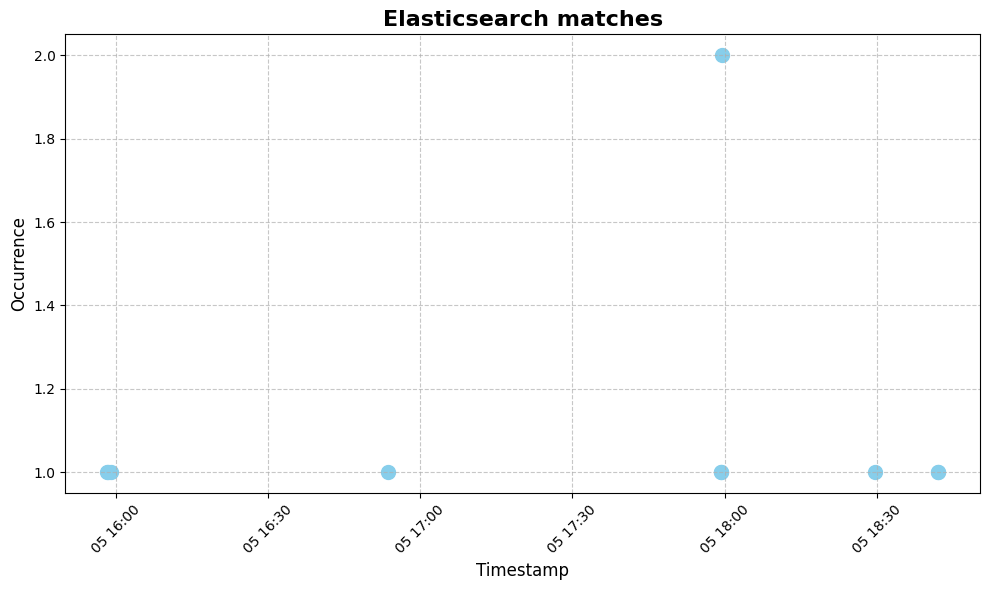

In [13]:
plot_title = "Elasticsearch matches"

timestamp_counts = defaultdict(int)
for hit in playbook_results["extracted_hits"]:
    timestamp_str = hit["@timestamp"]
    timestamp = datetime.strptime(timestamp_str, "%Y-%m-%dT%H:%M:%S.%fZ")
    timestamp_counts[timestamp] += 1

dates = sorted(timestamp_counts.keys())
values = [timestamp_counts[date] for date in dates]

plt.figure(figsize=(10, 6))
plt.scatter(dates, values, color='skyblue', s=100)  
plt.title(plot_title, fontsize=16, fontweight='bold')
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Occurrence", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines with transparency
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Save plot to buffer
buffer = io.BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)
plot_as_string = buffer.getvalue()

# Show plot
plt.show()

# Sightings

## SI:1 Add sightings to MISP

Now we'll add a MISP sighting for the occurences found in Elasticearch. You can set the source with `sighting_source` and the sighting type with `sighting_type`. For the latter, these values exist
- 0 = True **sighting**, the most common used option
- 1 = **False positive** sighting
- 2 = **Expiration** sighting

In [14]:
# Add sightings to MISP
sighting_source = "Set by playbook, detected in Elasticsearch"
sighting_type = 0  # Sighting types: 0=sighting ; 1=false positive ; 2=expiration

In [15]:
print("Adding sightings to MISP.")

for hit in playbook_results["extracted_hits"]:
    for sighting_value in hit["matched_highlights"]:
        dt = datetime.strptime(hit["@timestamp"], "%Y-%m-%dT%H:%M:%S.%fZ")
        dt = dt.replace(tzinfo=pytz.UTC)
        sighting_timestamp = dt.timestamp()
        sighting_source_add = "{} - {} - {}".format(sighting_source, hit["event.dataset"], hit["_id"])
        data = {"value": sighting_value, "type": sighting_type, "source": sighting_source_add, "timestamp": sighting_timestamp}
        request = misp._prepare_request("POST", "{}/sightings/add".format(misp_url), data=data)
        if "Sighting" in request.json():
            print(" Adding \033[92m{}\033[90m at {}: {}".format(sighting_value, hit["@timestamp"], sighting_source_add))
        else:
            print(" Unable to add sighting \033[91m{}\033[90m at {}".format(sighting_value, hit["@timestamp"]))
print("Finished adding sightings.")

Adding sightings to MISP.
 Adding ua-calendar.firstcloudit.com at 2024-07-05T18:42:11.991Z: Set by playbook, detected in Elasticsearch - zeek.dns - hzQ0hJABb6m2-P8cjDxe
 Adding militarysupport.firstcloudit.com at 2024-07-05T18:42:04.163Z: Set by playbook, detected in Elasticsearch - zeek.dns - ejQ0hJABb6m2-P8cjDxe
 Adding militarysupport.firstcloudit.com at 2024-07-05T18:29:40.098Z: Set by playbook, detected in Elasticsearch - zeek.dns - ETMphJABb6m2-P8cQSYp
 Adding ua-calendar.firstcloudit.com at 2024-07-05T17:59:34.276Z: Set by playbook, detected in Elasticsearch - zeek.dns - LDANhJABb6m2-P8clHAA
 Adding ua-calendar.firstcloudit.com at 2024-07-05T17:59:34.276Z: Set by playbook, detected in Elasticsearch - zeek.dns - KzANhJABb6m2-P8clHAA
 Adding militarysupport.firstcloudit.com at 2024-07-05T17:59:14.003Z: Set by playbook, detected in Elasticsearch - zeek.dns - OjANhJABb6m2-P8cRWk1
 Adding militarysupport.firstcloudit.com at 2024-07-05T17:59:14.002Z: Set by playbook, detected in Elast

# Closure

In this **closure** or end step we create a **summary** of the actions that were performed by the playbook. The summary is printed and can also be send to a chat channel. 

## EN:1 Create the summary of the playbook 

The next section creates a summary and stores the output in the variable `summary` in Markdown format. It also stores an intro text in the variable `intro`. These variables can later be used when sending information to Mattermost or TheHive.

In [16]:
summary = "# MISP Playbook summary\nQuery Elasticsearch for threat intelligence and report sightings in MISP and Mattermost \n\n"

current_date = datetime.now()
formatted_date = current_date.strftime("%Y-%m-%d")
summary += "## Overview\n\n"
summary += "- Date: **{}**\n".format(formatted_date)
summary += "- Elastic search between **{}** and **{}**\n".format(query_start, query_end)
summary += "- Elastic search limited to **{}** results\n".format(query_limit)
summary += "- Based on MISP query: **{}**\n".format(tag_query)
summary += "- Attribute types: **{}**\n".format(type_attribute)
summary += "- Resulting in MISP attributes: **{}**\n".format(playbook_results["attributes"])

summary += "## Elasticsearch matches\n\n"
summary += "### Matches\n\n"
summary += "- **MISP** attributes ({}): **{}**\n".format(len(playbook_results["unique_attributes_by_field_matches"]), playbook_results["unique_attributes_by_field_matches"])
summary += "- **{}** ({}): **{}**\n".format(unique_attributes_by_field, len(playbook_results["unique_attributes_by_field"]), playbook_results["unique_attributes_by_field"])
summary += "### Documents\n\n"
summary += "There were **{}** documents found in Elasticsearch that match with **{}**.\n\n".format(len(playbook_results["extracted_hits"]), playbook_results["unique_attributes_by_field_matches"])
table_elasticsearch.set_style(MARKDOWN)
summary += table_elasticsearch.get_string()
summary += "\n\n"

print("The \033[92msummary\033[90m of the playbook is available.\n")

The summary of the playbook is available.



## EN:2 Print the summary

In [17]:
print(summary)
# Or print with parsed markdown
#display_markdown(summary, raw=True)

# MISP Playbook summary
Query Elasticsearch for threat intelligence and report sightings in MISP and Mattermost 

## Overview

- Date: **2024-07-05**
- Elastic search between **2020-01-01T00:00:00.000Z** and **2024-07-05T18:43:24.008Z**
- Elastic search limited to **100** results
- Based on MISP query: **{'AND': ['tlp:white', 'workflow:state="complete"'], 'NOT': ['workflow:state="rejected"'], 'OR': ['misp-galaxy:threat-actor="Sofacy"', 'misp-galaxy:mitre-intrusion-set="APT28 - G0007"', 'misp-galaxy:threat-actor="Sofacy"', 'misp-galaxy:threat-actor="APT28"']}**
- Attribute types: **['hostname', 'domain', 'ip-src', 'ip-dst']**
- Resulting in MISP attributes: **['9b5uja.am.files.1drv.com', 'kdmzlw.am.files.1drv.com', 'ua-calendar.firstcloudit.com', 'info-mod.firstcloudit.com', 'e-mod.firstcloudit.com', 'militarysupport.firstcloudit.com', 'e-presidencia.firstcloudit.com']**
## Elasticsearch matches

### Matches

- **MISP** attributes (2): **['militarysupport.firstcloudit.com', 'ua-calendar

## EN:3 Send a summary to Mattermost

Now you can send the summary to Mattermost. You can send the summary in two ways by selecting one of the options for the variable `send_to_mattermost_option` in the next cell.

- The default option where the entire summary is in the **chat**, or
- a short intro and the summary in a **card**

For this playbook we rely on a webhook in Mattermost. You can add a webhook by choosing the gear icon in Mattermost, then choose Integrations and then **Incoming Webhooks**. Set a channel for the webhook and lock the webhook to this channel with *"Lock to this channel"*.

In [18]:
send_to_mattermost_option = "via a chat message"
#send_to_mattermost_option = "via a chat message with card"

In [19]:
buffer_base64 = base64.b64encode(plot_as_string).decode()
data_url = f"data:image/png;base64,{buffer_base64}"
attachment = [{"fallback": "Decaying of indicators","color": "#ff8000","image_url": data_url}]

message = False

if send_to_mattermost_option == "via a chat message":
    message = {"username": mattermost_playbook_user, "text": summary, "attachments": attachment}
elif send_to_mattermost_option == "via a chat message with card":
    message = {"username": mattermost_playbook_user, "text": intro, "props": {"card": summary}, "attachments": attachment}

if message:
    r = requests.post(mattermost_hook, data=json.dumps(message))
    r.raise_for_status()
if message and r.status_code == 200:
    print("Summary is \033[92msent to Mattermost.\n")
else:
    print("\033[91mFailed to sent summary\033[90m to Mattermost.\n")

Summary is sent to Mattermost.



## EN:4 End of the playbook 

In [20]:
print("\033[92m End of the playbook")


 End of the playbook


## External references <a name="extreferences"></a>

- [The MISP Project](https://www.misp-project.org/)
- [Mattermost](https://mattermost.com/)

## Technical details 

### Documentation

This playbook requires these Python **libraries** to exist in the environment where the playbook is executed. You can install them with `pip install <library>`.

```
PrettyTable
ipywidgets
matplotlib
io
```

### Colour codes

The output from Python displays some text in different colours. These are the colour codes

```
Red = '\033[91m'
Green = '\033[92m'
Blue = '\033[94m'
Cyan = '\033[96m'
White = '\033[97m'
Yellow = '\033[93m'
Magenta = '\033[95m'
Grey = '\033[90m'
Black = '\033[90m'
Default = '\033[99m'
```